In [157]:
import argparse
import pprint
import logging
from typing import get_args
import torch

import numpy as np
import tqdm as tqdm
import ipdb

import time
import seaborn as sns
import matplotlib.pyplot as plt
from dance import logger
from pathlib import Path
import pickle
from dance.datasets.singlemodality import CellTypeAnnotationDataset
from dance.modules.single_modality.cell_type_annotation.actinn import ACTINN
from dance.typing import LogLevel
from dance.utils import set_seed

In [2]:
logger.setLevel(logging.INFO)
# logger.info(f"Running SVM with the following parameters:\n{pprint.pformat(vars(args))}")

In [3]:
train_dataset = ['753', '3285']
test_dataset = ['2695']
species = "mouse"
tissue = "Brain"
val_size = 0.0

dataloader = CellTypeAnnotationDataset(train_dataset=train_dataset, test_dataset=test_dataset,
                                           tissue=tissue, species=species, val_size=val_size)

In [46]:
lambd = 0.005
model = ACTINN(hidden_dims=[512], lambd=lambd, device="cpu", use_feature_embedding=True)
preprocessing_pipeline = model.preprocessing_pipeline(normalize=True, filter_genes=True)

In [47]:
preprocessing_pipeline

Compose(
  AnnDataTransform(func=scanpy.preprocessing._normalization.normalize_total, func_kwargs={'target_sum': 10000.0}),
  AnnDataTransform(func=scanpy.preprocessing._simple.log1p, func_kwargs={'base': 2}),
  AnnDataTransform(func=scanpy.preprocessing._simple.filter_genes, func_kwargs={'min_cells': 1}),
  FilterGenesPercentile(min_val=1, max_val=99, mode='sum'),
  FilterGenesPercentile(min_val=1, max_val=99, mode='cv'),
  SetConfig(config_dict={'label_channel': 'cell_type'}),
)

In [48]:
data = dataloader.load_data(transform=preprocessing_pipeline, cache=False)

[INFO][2024-10-20 16:18:18,503][dance][_load_dfs] Loading data from ./train/mouse/mouse_Brain753_data.csv


[INFO][2024-10-20 16:18:19,005][dance][_load_dfs] Loading data from ./train/mouse/mouse_Brain3285_data.csv
[INFO][2024-10-20 16:18:21,660][dance][_load_dfs] Loading data from ./test/mouse/mouse_Brain2695_data.csv
[INFO][2024-10-20 16:18:24,185][dance][_load_dfs] Loading data from ./train/mouse/mouse_Brain753_celltype.csv
[INFO][2024-10-20 16:18:24,190][dance][_load_dfs] Loading data from ./train/mouse/mouse_Brain3285_celltype.csv
[INFO][2024-10-20 16:18:24,196][dance][_load_dfs] Loading data from ./test/mouse/mouse_Brain2695_celltype.csv
/opt/homebrew/Caskroom/miniconda/base/envs/dance/lib/python3.11/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
[INFO][2024-10-20 16:18:25,239][dance][_load_raw_data] Loaded expression data: AnnData object with n_obs × n_vars = 6733 × 19856
[INFO][2024-10-20 16:18:25,239][dance][_load_raw_data] Number of training samples: 4,038
[INFO][2024-10-20 16:18:25,239]

In [49]:
gene_names = data.data.var.index.tolist()

In [89]:
import requests
import xml.etree.ElementTree as ET 


In [155]:
def get_gene_info(gene_name, verbose=False):
    if verbose:
        print(f"Getting gene info for {gene_name}")
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=nucleotide&term={gene_name}"
    # # url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=nucleotide&term={gene_name}"
    # url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&term={gene_name}"
    response = requests.get(url)
    if not response.status_code == 200:
        if verbose:
            print(f"Failed to get gene info for {gene_name}")
        return None
    
    root = ET.fromstring(response.content)
    id_tags = root.find('IdList').findall('Id')
    ids = [id_tag.text for id_tag in id_tags]
    if len(ids) == 0:
        if verbose:
            print(f"No gene info found for {gene_name}")
        return None
    
    info_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=nucleotide&id={}&version=2.0"
    chosen_id = None
    for identifier in ids:
        response = requests.get(info_url.format(identifier))
        if not response.status_code == 200:
            if verbose:
                print(f"Failed to get gene info for {gene_name}")
            return None
        
        root = ET.fromstring(response.content)
        sequence_length = root.find('DocumentSummarySet').find('DocumentSummary').find('Slen') # find('Slen'))
        if sequence_length is None:
            continue
        
        sequence_length = int(sequence_length.text)
        if sequence_length <= 4096:
            chosen_id = identifier
            break
        

    if chosen_id is None:
        if verbose:
            print(f"No gene info found for {gene_name}")
        return None
    
    fasta_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id={chosen_id}&rettype=fasta&retmode=text"
    response = requests.get(fasta_url)
    if not response.status_code == 200:
        if verbose:
            print(f"Failed to get gene info for {gene_name}")
        return None
    
    # Drop first line
    response = response.text.split("\n")[1:]
    rna = "".join(response).replace("\n", "")

    # Assert it's RNA i.e. all characters are in ['A', 'C', 'G', 'T', 'U']
    if not all([char in ['A', 'C', 'G', 'T', 'U'] for char in rna]):
        if verbose:
            print(f"Failed to get gene info for {gene_name}")
        return None
        
    return rna

In [148]:
out = get_gene_info(gene_names[1], verbose=True)
print(out)

Getting gene info for 0610009B22Rik
ATTTTGCTTTCTGGCATTCTTGTAGTTAAAAGCTCCGCCTCACTTGGCAGTCTGGTCCACATCTCCCGCCAGGCTTCCGGTCTCTACACCTCCAGGCGAACGTCAGTGACAACATAAGCAAGTACGCGTGCGGTGAAGGCAAGGATTGCTCTAAGAGCCAGAGGAGGCCCGCGGGGACCCCGACGTCCCATGAGGCCTTGACCCAAGATGGCGGACAAAACCCTTAGCGCAGCCTTGCTCAGAGACGCATGTGCGCATGCCCGGTCGACTGAGCTGCCCTGATCCAAGATGGCGGCCGGACCGGGGCTGGGGACGGGCTTAGCGCGTTACTGAGCATGCTCAGTCTTCCGTCACTTGCGTCAGGTCGGCAGCCGGCGCAGGCCGCTCAGTCCTTCCCGGAGAGGCGGGAACATGAGCCACATATAGACAGAAGACAATGTCTGGGAGCTTCTACTTCGTAATTGTTGGCCACCATGATAATCCGGTTTTTGAAATGGAATTTTTGCCAGCTGGGAAAGCAGAATCTAAAGATGAACACCGTCATCTGAACCAGTTCATAGCTCATGCTGCTCTGGACCTCGTCGACGAAAACATGTGGCTCTCCAACAACATGTACTTAAAAACTGTGGACAAATTCAATGAGTGGTTCGTCTCGGCGTTCGTCACGGCTGGGCACATGCGGCTCATCATGCTGCATGACGTGAGGCACGAGGATGGCATCAAGAACTTCTTCACTGACGTCTACGACTTATACATCAAATTTGCCATGAATCCCTTTTATGAACCCAATTCTCCTATTCGATCGAGTGCATTCGAAAGAAAAGTTCAGTTTCTTGGGAAGAAACATCTTTTAAACTAAATGCAGAAAAACTTCAGAATCACAGTGGGGTGTGCTCAGCAGTGGATGTATTGTAAATTACTTGATAAAGTAGCCTAGCAAACTCTTTATGTCTCAGCTTACCTG

In [160]:
# gene_to_rna = {}
# missed_count = 0

gene_map_path = Path("/Users/burgerm/projects/petagraph/dance/examples/single_modality/cell_type_annotation")
gene_map_file = gene_map_path / "gene_to_rna.pkl"

if gene_map_file.exists():
    with open(gene_map_file, "rb") as f:
        gene_to_rna = pickle.load(f)
    print(f"Loaded gene map file with {len(gene_to_rna)} entries")
else:
    print("No gene map file found")



Loaded gene map file with 265 entries


In [154]:
for gene_name in tqdm.tqdm(gene_names):

    if gene_name in gene_to_rna:
        continue

    rna = get_gene_info(gene_name)
    if rna is not None:
        gene_to_rna[gene_name] = rna
    else:
        missed_count += 1
    
    time.sleep(0.5)

print(f"Missed {missed_count} genes")
print(f"Got {len(gene_to_rna)} genes")
print(f"Total {len(gene_names)} genes")

  6%|▌         | 1071/18162 [38:34<54:55:43, 11.57s/it]

In [159]:
# Save gene_to_rna
with open(gene_map_file, 'wb') as f:
    pickle.dump(gene_to_rna, f)

In [53]:
x_train, y_train = data.get_train_data(return_type="torch")
x_test, y_test = data.get_test_data(return_type="torch")

x_all = torch.cat([x_train, x_test], dim=0)
y_all = torch.cat([y_train, y_test], dim=0)

In [54]:
x_all[:, 0].sum()

tensor(20.7030)

In [55]:
x_all.max()

tensor(6.7391)

<Axes: ylabel='Count'>

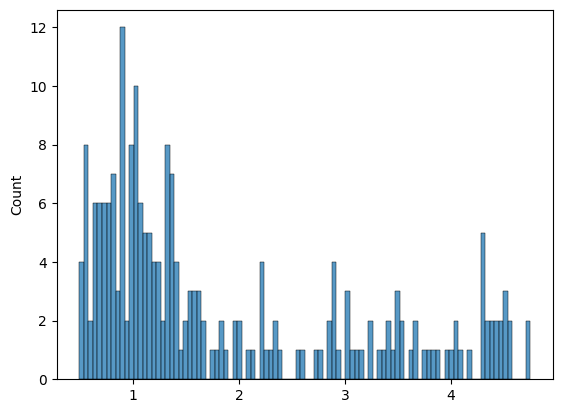

In [62]:
data = x_all[:, 3].numpy()
sns.histplot(data[data > 0], bins=100)